In [1]:
trace_file = 'trace_0.paje'
archives = {'smpi': 'grenoble_2018-09-25_1809958.zip',
           'real': '../hpl/grenoble_2018-09-25_1809910.zip'}

pajeng_install = '~/pajeng_install'
directories = {'smpi': '/tmp/smpi', 'real': '/tmp/real'}

for directory in directories.values():
    !rm -rf $directory && mkdir -p $directory

## Simulation

In [2]:
exp = 'smpi'
archive = archives[exp]
directory = directories[exp]

In [3]:
!unzip -p $archive $trace_file | LD_LIBRARY_PATH=$pajeng_install/lib/ $pajeng_install/bin/pj_dump > $directory/trace.csv
!wc -l $directory/trace.csv

7920370 /tmp/smpi/trace.csv


In [4]:
!grep State     $directory/trace.csv > $directory/trace_state.csv
!grep Link      $directory/trace.csv > $directory/trace_link.csv
!grep Container $directory/trace.csv > $directory/trace_container.csv
!wc -l $directory/trace_*.csv

      513 /tmp/smpi/trace_container.csv
  1208356 /tmp/smpi/trace_link.csv
  6711501 /tmp/smpi/trace_state.csv
  7920370 total


In [5]:
import pandas
from plotnine import *

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
df_state = pandas.read_csv(directory + '/trace_state.csv', names=['Type', 'Rank', 'Container', 'Start', 'End', 'Duration', 'Level', 'State'])
df_state = df_state.drop(['Type', 'Container', 'Level'], axis=1)
df_state.Rank = df_state.Rank.apply(lambda s: s[s.index('-')+1:]).astype(int)
df_state.State = df_state.State.apply(lambda s: s.replace('PMPI', 'MPI'))
df_state = df_state[df_state.State != 'MPI_Init']
df_state.head()

,Rank,Start,End,Duration,State
0,99,0.000000,0.000000,0.000000,MPI_Init
1,99,0.000000,0.000010,0.000010,computing
2,99,0.000010,0.000012,0.000002,MPI_Recv
3,99,0.000012,0.000015,0.000003,computing
4,99,0.000015,0.000015,0.000000,MPI_Send


In [7]:
df_link = pandas.read_csv(directory + '/trace_link.csv', names=['Type', 'Level', 'Container', 'Start', 'End', 'Duration', 'CommType', 'Src', 'Dst', 'Key'])
df_link = df_link.drop(['Type', 'Container', 'Level', 'CommType', 'Key'], axis=1)
df_link.Src = df_link.Src.apply(lambda s: s[s.index('-')+1:]).astype(int)
df_link.Dst = df_link.Dst.apply(lambda s: s[s.index('-')+1:]).astype(int)
df_link.head()

,Start,End,Duration,Src,Dst
0,0.000006,0.000008,0.000002,506,505
1,0.000006,0.000008,0.000002,512,511
2,0.000006,0.000009,0.000003,510,509
3,0.000006,0.000009,0.000003,504,503
4,0.000006,0.000009,0.000003,498,497


In [10]:
def draw_plot(state_dataframe, link_dataframe, time_interval, ranks):
    tmp_state = state_dataframe[(state_dataframe.Start >= time_interval[0]) & (state_dataframe.End <= time_interval[1]) & (state_dataframe.Rank.isin(ranks))].copy()
    tmp_state['rankplusone'] = tmp_state.Rank + 1
    tmp_link = link_dataframe[(link_dataframe.Start >= time_interval[0]) & (link_dataframe.End <= time_interval[1]) & (link_dataframe.Src.isin(ranks)) & (link_dataframe.Dst.isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='Start', xmax='End', ymin='Rank', ymax='rankplusone',fill='State')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme()
    print(gc)
    gc += geom_segment(tmp_link, aes(x = 'Start', y = 'Src', xend = 'End', yend = 'Dst'), arrow = arrow(length = 0.1))
    print(gc)

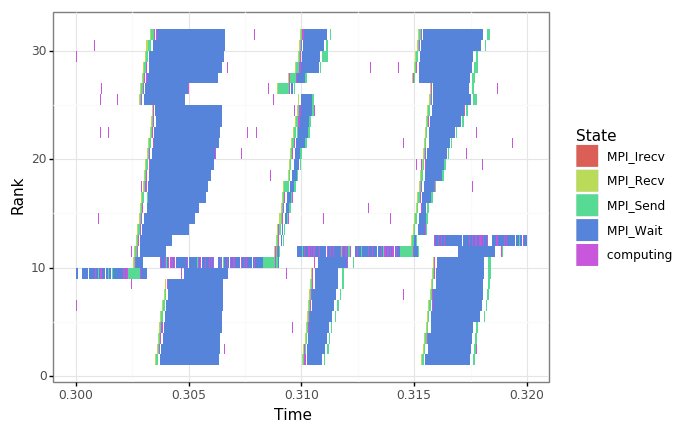

<ggplot: (-9223363302654833934)>


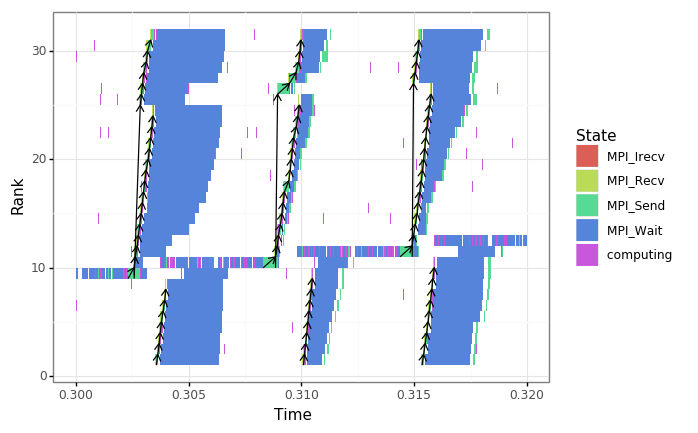

<ggplot: (-9223363302654833934)>


In [11]:
draw_plot(df_state, df_link, time_interval=(0.3, 0.32), ranks=range(32))

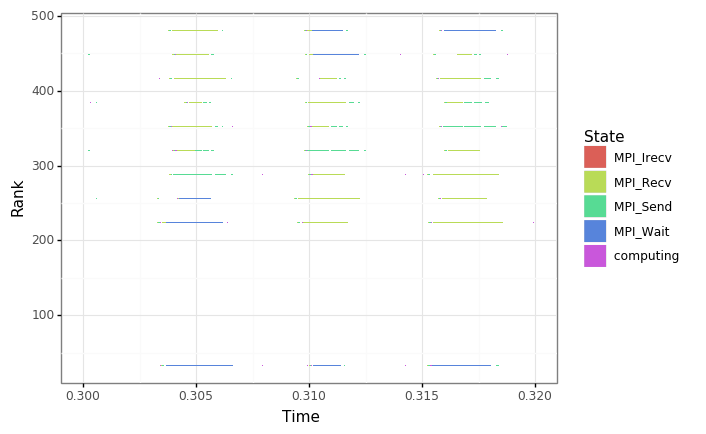

<ggplot: (-9223363302650891765)>


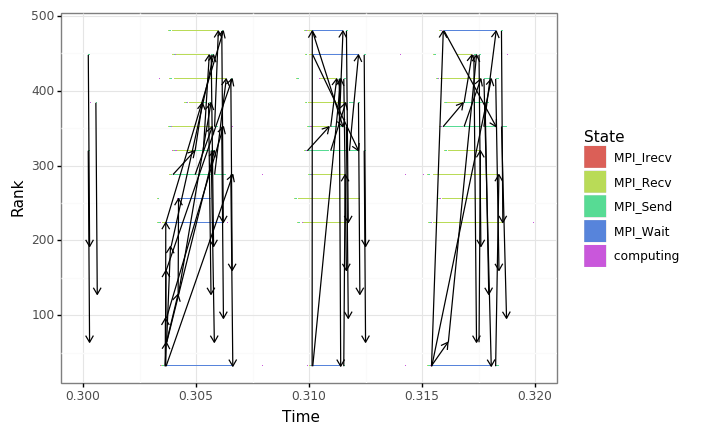

<ggplot: (-9223363302650891765)>


In [12]:
draw_plot(df_state, df_link, time_interval=(0.3, 0.32), ranks=[32*i for i in range(16)])